In [9]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt

# Load four letter words 

In [2]:
# Kucera & Francis Word Pool downloaded from http://memory.psych.upenn.edu/files/wordpools/kfpool.txt
kf_corpus = pd.read_csv('kfpool.txt', header=None, sep=' ', names=['word', 'frequency'])

kf_corpus

,word,frequency
0,a,23248
1,a-coming,2
2,a-crowing,1
3,a-drinking,1
4,a-gracious,1
...,...,...
46367,zur,2
46368,zurcher,2
46369,zurich,2
46370,zwei,1


Let's see how many four letter words there are in the corpus.

In [3]:
(kf_corpus.word.str.len() == 4).sum()

2347

That is more than 1179 words reported in McClelland & Rumelhart, 1981. Probably they filtered by frequency.

In [4]:
for i in range(7):
    word_count = len(kf_corpus[(kf_corpus.word.str.len() == 4) & (kf_corpus.frequency > i)])
    print(f'There are {word_count} four letter words with frequency larger than {i}')

There are 2347 four letter words with frequency larger than 0
There are 1721 four letter words with frequency larger than 1
There are 1444 four letter words with frequency larger than 2
There are 1294 four letter words with frequency larger than 3
There are 1188 four letter words with frequency larger than 4
There are 1092 four letter words with frequency larger than 5
There are 1029 four letter words with frequency larger than 6


Frequency threshold of 4 yields the number closest to 1179.

In [5]:
four_letter_words = kf_corpus[(kf_corpus.word.str.len() == 4) & (kf_corpus.frequency > 4)]
len(four_letter_words)

1188

# Encode letters as feature bundles 

In the original model, the input letters came from a simplified font in which each letter is composed of a number of simplified line strokes (*features*) as in the following image:

![Font from Rumelhar & Siple, 1974](rumelhart-siple-font.jpg)

Here are all the features numbered from 0 to 13:

![Numbered line features](line_features.png)

A list of letters specifying which features it is composed of.

In [6]:
feature_numbers = {
    'A': [0, 1, 2, 3, 4, 6, 8],
    'B': [2, 3, 4, 5, 7, 8, 9],
    'C': [0, 1, 2, 5],
    'D': [2, 3, 4, 5, 7, 9],
    'E': [0, 1, 2, 5, 6],
    'F': [0, 1, 2, 6],
    'G': [0, 1, 2, 4, 5, 8],
    'H': [0, 1, 3, 4, 6, 8],
    'I': [2, 5, 7, 9],
    'J': [0, 3, 4, 5],
    'K': [0, 1, 6, 11, 12],
    'L': [0, 1, 5],
    'M': [0, 1, 3, 4, 10, 11],
    'N': [0, 1, 3, 4, 10, 12],
    'O': [0, 1, 2, 3, 4, 5],
    'P': [0, 1, 2, 3, 6, 8],
    'Q': [0, 1, 2, 3, 4, 5, 12],
    'R': [0, 1, 2, 3, 6, 8, 12],
    'S': [1, 2, 4, 5, 6, 8],
    'T': [2, 7, 9],
    'U': [0, 1, 3, 4, 5],
    'V': [0, 1, 11, 13],
    'W': [0, 1, 3, 4, 12, 13],
    'X': [10, 11, 12, 13],
    'Y': [9, 10, 11],
    'Z': [2, 5, 11, 13]
}

Let's draw all the letter to check that we got everything right. First, we need the coordinates of all features.

In [7]:
feature_coordinates = {
    0: [(-1, -1), (-1, 0)],
    1: [(-1, 0), (-1, 1)],
    2: [(-1, 1), (1, 1)],
    3: [(1, 1), (1, 0)],
    4: [(1, 0), (1, -1)],
    5: [(1, -1), (-1, -1)],
    6: [(0, 0), (-1, 0)],
    7  : [(0, 0), (0, 1)],
    8 : [(0, 0), (1, 0)],
    9 : [(0, 0), (0, -1)],
    10 : [(0, 0), (-1, 1)],
    11 : [(0, 0), (1, 1)],
    12 : [(0 ,0), (1, -1)],
    13 : [(0, 0), (-1, -1)]
}

Function that draws one letter:

In [37]:
def draw_letter(feature_list, feature_coordinates, axes):
    axes.grid()
    axes.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
    
    # Remove ticks and labels from the axes
    axes.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
   
    for line_nmbr in feature_list:
        line_coords = feature_coordinates[line_nmbr]
        x_values = [line_coords[0][0], line_coords[1][0]]
        y_values = [line_coords[0][1], line_coords[1][1]]
        plt.plot(x_values, y_values, color = 'k', linewidth = 4)

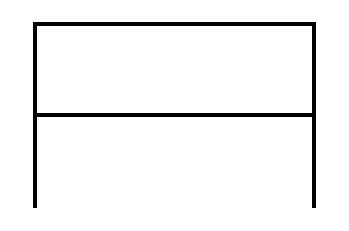

In [47]:
plt.plot()
axes=plt.gca()
draw_letter(feature_list=feature_numbers['A'], 
            feature_coordinates=feature_coordinates, 
            axes=axes)


Now, let's draw all of them.

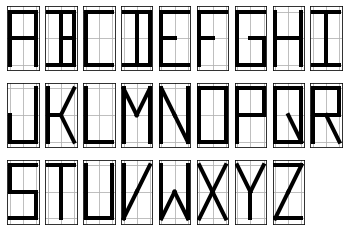

In [48]:
def draw_letter_list(letter_list, feature_numbers, feature_coordinates):
    N_letters = len(letter_list)
    fig, axs = plt.subplots(3, 9)
    for axes, lttr in zip(axs.flatten()[:N_letters], letter_list):
        plt.sca(axes)
        draw_letter(feature_numbers[lttr], feature_coordinates, axes)
    
    # Clear the last empty axes
    axs.flatten()[-1].axis('off');
    
draw_letter_list(sorted(feature_numbers.keys())[:26], feature_numbers, feature_coordinates)

![Font from Rumelhar & Siple, 1974](rumelhart-siple-font.jpg)

Looks correct.